In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:

filesdir = "/ocean/gsgarbi/selected_days/"

dirs = os.listdir(filesdir)



Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

In [3]:
def plot(points, title = 'title', picname = "noname", b=0):
    
    
    cmap = plt.get_cmap('nipy_spectral')
    cmap.set_bad('burlywood')


    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)

    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape


    griddata, iedges, jedges = np.histogram2d(points[:,1],points[:,2],
                                                  bins=[100,200],
                                                  range=[lonlim,latlim])


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(5,4))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap)
    mesh0.set_clim(vmin = 0)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3],pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    

    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "  IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = 'white',
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.contour(LON,LAT,B,levels=[50,], colors = ['w',], linewidths = [0.8,])
        
    xc = np.mean(points[:,1])
    yc = np.mean(points[:,2])
    xs = np.std(points[:,1])
    ys = np.std(points[:,2])
    
    axs2.plot(xc,yc,"kx", ms = 10)
    
    axs.set_title( title + "\n Total of trajectories: {} \n".format( 
        int(np.sum(griddata)) ) + "STD: ({}, {})".format(round(xs,2), 
                                                         round(ys,2)) +
                 " Centroid: ({}, {})".format (round(xc, 2), round(yc, 2))
                                                        )
    
    
    plt.savefig(picname, transparent = True)
    


In [4]:
def lessthan (filesdir, nday = 30, month =7, ppd = 72, enddate = 0):
    dirs = os.listdir(filesdir)
    
    #choose and format month
    m = month-1
    if len(str(m)) == 1:
        m = "0"+str(m)
    
    #choose files in dirs based on nday and enddate
    dirs = sorted ([i for i in dirs if i[4:6] == m])
    
    pts = []
    

    #first code for a single month
    for i in dirs:
        
        for day in range (nday-1, -1,-1):
            
            traj_l = nday - day

            if "{}d.npy".format(traj_l) == i [18:]:

                array = np.load(open(filesdir + i, 'rb'))
                
                array = array [ppd*day:ppd*(day+1)]

                pts.append(array)
                


    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

In [5]:
def create_array(filesdir, nday):
    
    dirs = os.listdir(filesdir)

    dirs = sorted(dirs)
    
    pts = []
    
    for day in range (1, nday+1):
        

        for i in dirs:

            if "{}d.npy".format (day) == i [18:] and "2016" == i [:4]: #select length

                array = np.load(open(filesdir + i, 'rb'))

                pts.append(array)

    pts = np.array([i for sublist in pts for i in sublist])

    
    return pts

In [6]:
a = lessthan(filesdir)
print (a)

[[  1.44100000e+03  -1.23608220e+02   4.91053400e+01  -5.94211300e+01
    3.41300000e-02]
 [  1.44200000e+03  -1.23368700e+02   4.90301300e+01  -7.48628800e+01
    3.41300000e-02]
 [  1.44300000e+03  -1.23596480e+02   4.92944200e+01  -1.07402600e+02
    3.41300000e-02]
 ..., 
 [  1.58200000e+03  -1.23562880e+02   4.92588000e+01  -7.74372600e+01
    3.07200000e-02]
 [  1.58300000e+03  -1.23426690e+02   4.91253900e+01  -4.88368100e+01
    3.07200000e-02]
 [  1.58400000e+03  -1.23276960e+02   4.93249300e+01  -1.11980810e+02
    3.07200000e-02]]


start:  2017-06-28 19:09:08.844290


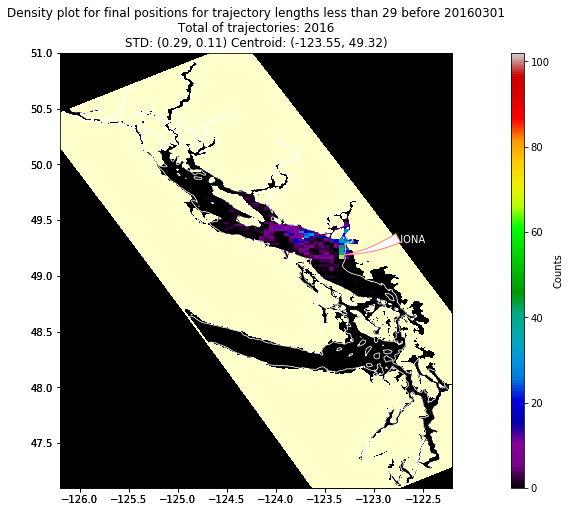

start:  2017-06-28 19:09:09.945245


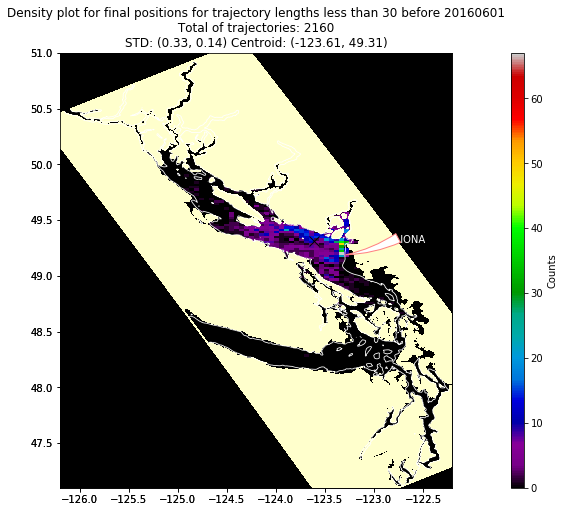

start:  2017-06-28 19:09:11.030185


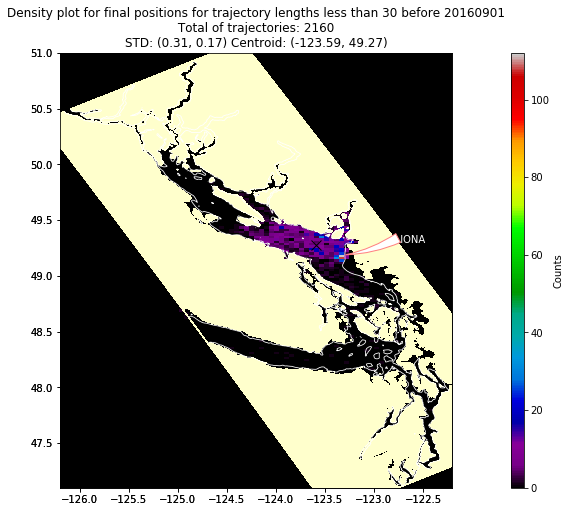

In [7]:
for month in (3,6,9):

    if month == 3:
        nday = 29
    else:
        nday = 30

    points = lessthan(filesdir, nday = nday, month = month)

    m = str(month)
    if len(m) == 1:
        m = "0"+str(m)

    title = (
        "Density plot for final positions for trajectory lengths less than {} before 2016{}01".format(nday, m)
    )

    picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}_{}d_lessthan".format(month, nday)

    plot (points, title, picname)


    plt.show()

In [8]:
fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
nav_lon = np.copy(fb.variables['nav_lon'])
nav_lat = np.copy(fb.variables['nav_lat'])
bathy = np.copy(fb.variables['Bathymetry'])
fb.close()
thw = np.loadtxt(
    '/ocean/gsgarbi/MEOPAR/tools/bathymetry/thalweg_working.txt',
    delimiter=" ", dtype=int)

print (thw)
thw_lat = nav_lat[thw[:,0], thw[:,1]]
thw_lon = nav_lon[thw[:,0], thw[:,1]]




[[406   2]
 [406   3]
 [406   4]
 ..., 
 [896  43]
 [896  42]
 [897  42]]


In [9]:
def plot_thw(points, title = 'title', picname = "noname", b=0):
    
    
    cmap = plt.get_cmap('nipy_spectral')
    cmap.set_bad('burlywood')


    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)

    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()



    

    fig, axs = plt.subplots(1,1,figsize=(9,8))
    mesh1=axs2.pcolormesh(nav_lon,nav_lat,np.ma.masked_where(tmask[0,0,:,:]==1,tmask[0,0,:,:]),cmap='YlOrRd')
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    cbar.set_label ("Counts")
    

    
    el = Ellipse((2, -1), 0.5, 0.5)

    axs2.annotate(
            "  IONA",
            xy=(Iona[0], Iona[1]), xytext=(50, 10),
            textcoords='offset points', ha='left', va='bottom', color = 'white',
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1"))

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.plot(thw_lon, thw_lat, 'bo')

    
    axs.set_title( title)
    
    
    plt.savefig(picname, transparent = True)